# Introduction


### Settings

In [1]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Settings
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

GDRIVE_MOUNT_POINT = '/content/drive'
PROJECT_DIR = GDRIVE_MOUNT_POINT + '/MyDrive/Mushroom_project' 
PY_LIB_DIR = PROJECT_DIR + '/src/lib'
SRC_DIR = PROJECT_DIR + '/datasource/mushroomObserver/dataframes/clean'

IMG_DIR=PROJECT_DIR + "/datasource/mushroomObserver/images"

WORK_DIR = "/content/drive/MyDrive/work/Oliv"

IMG_DIR = WORK_DIR + "/images"

WORK_DIR_DAD= "/content/drive/MyDrive/work/dad/transfert/images"


### Import libraries

In [2]:
# Importing standard libraries
#
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import seaborn as sns

from shutil import copyfile, rmtree

from keras import backend as K
from keras.preprocessing import image
from tensorflow.keras import models

from skimage import io
import cv2
import matplotlib.cm as cm

from IPython.display import Image, display

import random

from sklearn import metrics
from sklearn.model_selection import train_test_split

 

In [3]:
# Optional - Pre-requisites 
#
# Mounting Google drive if not already done
if not os.path.isdir(GDRIVE_MOUNT_POINT):
  drive.mount(GDRIVE_MOUNT_POINT)


Mounted at /content/drive


###Data preparation

In [6]:
# Loading Data

df_genus = pd.read_csv( \
      filepath_or_buffer = SRC_DIR + '/' + "df_genus.csv"
   ,  sep = ','
   ,  header = 0
)

#specify image link within Google Drive
for i in range(len(df_genus)):
     df_genus.loc[i,"img_path"]= IMG_DIR + "/" + df_genus.loc[i,"taxon_name"] + "/" + str(int(df_genus.loc[i,"image_id"]))+".jpg"



In [7]:
print(df_genus.shape)
df_genus.head(2)

(35000, 37)


,obs_id,obs_date,is_collection_location,confidence,obs_views,consensus_id,consensus_name,consensus_rank,consensus_synonym_id,location_id,location_name,primary_image_id,primary_image_date,primary_image_license,primary_image_quality,taxon_id,taxon_name,taxon_rank,deprecated,misspelled,domain,kingdom,phylum,class,order,family,image_id,image_date,image_license,image_quality,image_notes,image_views,image_ok_for_export,image_url,image_type,image_format,img_path
0,536,2002-07-09,True,NaN,52,388,Agaricus,genus,240,1859,"Ucluelet, British Columbia, Canada",680,2002-07-09,Creative Commons Wikipedia Compatible v3.0,NaN,388,Agaricus,genus,False,False,Eukarya,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Agaricaceae,681.0,2002-07-09,Creative Commons Wikipedia Compatible v3.0,NaN,<p>Loaded from Agaricus/species/2002-07-09-1.j...,13.0,True,https://mushroomobserver.org/images/640/681.jpg,jpg,640,/content/drive/MyDrive/work/Oliv/images/Agaric...
1,537,2001-05-12,True,NaN,132,388,Agaricus,genus,240,92,"Barton Flats, San Bernardino National Forest, ...",682,2001-05-12,Creative Commons Wikipedia Compatible v3.0,NaN,388,Agaricus,genus,False,False,Eukarya,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Agaricaceae,683.0,2001-05-12,Creative Commons Wikipedia Compatible v3.0,NaN,<p>Loaded from Agaricus/species/2001-05-12-2.j...,18.0,True,https://mushroomobserver.org/images/640/683.jpg,jpg,640,/content/drive/MyDrive/work/Oliv/images/Agaric...


In [31]:
#First method

#Use comments associated to images to filter images with microscopic mushrooms
#find images to remove
init_size= df_genus.shape
df_genus["image_notes"].fillna(value="", inplace=True)

def filter(x):
  condition= ((x.find("Microscopy")>=0) * 1 +
              (x.find("microscopy")>=0) * 1 +
              (x.find("Spores")>=0) * 1 +
              (x.find("spores")>=0) * 1 +
              (x.find("Spore")>=0) * 1 +
              (x.find("spore")>=0) * 1 +
              (x.find("water")>=0) * 1 +
              (x.find("x")>=0) * 1  + 
              (x.find("micron")>=0) * 1 )
                  
  return condition

df_genus["filter1"]=df_genus["image_notes"].apply(lambda x: filter(x))
df_genus_filtered = df_genus[df_genus["filter1"]>=1]
df_genus_filtered.reset_index(inplace=True)

print("Number of images to filter : ", df_genus_filtered.shape[0])

Number of images to filter :  (1185, 39)


In [ ]:
#Then copy the images to a specific folder : 
for i in range(df_genus.shape[0]):
  if df_genus.loc[i,"filter1"]>=1:
    copyfile(df_genus.img_path[i], WORK_DIR+ "/rebus_2/" + str(int(df_genus.image_id[i])) + ".jpg" )
    #print(df_genus.img_path[i], "rebus!")
    print(i)


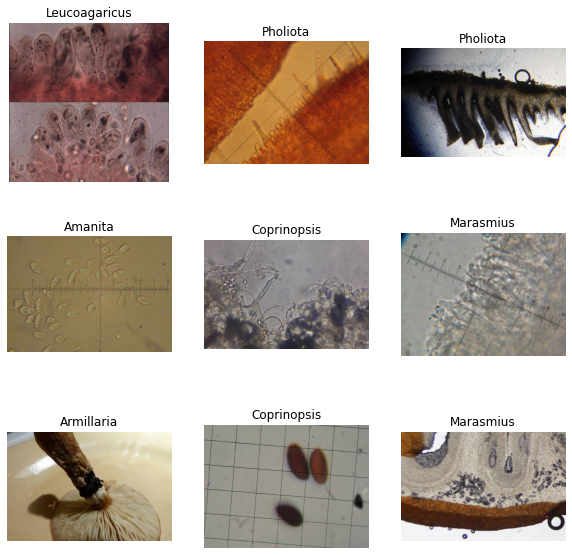

In [32]:
#We can show some images that have been filtered
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  k = random.randint(0,df_genus_filtered.shape[0])
  img  =io.imread(df_genus_filtered.loc[k,"image_url"])
  plt.imshow(img)
  plt.title(df_genus_filtered.taxon_name[k])
  plt.axis("off")

In [ ]:
#Second method

def filter_image(img):

  B, G, R= cv2.split(img)
  C=B+G+R
  #print(np.mean(C), np.mean(B), np.mean(G),np.mean(R))
  #print(np.std(C), np.std(B), np.std(G), np.std(R))
  #print(np.std(C)/np.mean(C),np.std(B)/np.mean(B),np.std(G)/np.mean(G), np.std(R)/np.mean(R) )
  #print((np.mean(C)-np.median(C))/np.std(C),(np.mean(B)-np.median(B))/np.std(B),(np.mean(G)-np.median(G))/np.std(G),(np.mean(R)-np.median(R))/np.std(R))
  condition1= (np.mean(C) > 100 ) & (np.mean(C) < 160)   #initial ts : 150
  condition2= (np.std(B)/np.mean(B) < 0.25) | (np.std(G)/np.mean(G) < 0.25)  | (np.std(R)/np.mean(R) < 0.25)
  condition2b= (np.std(B)/np.mean(B) < 0.25) & (np.std(G)/np.mean(G) < 0.25)  & (np.std(R)/np.mean(R) < 0.25)
  condition3= np.std(C)/np.mean(C) > 1.1  #Threshold 1.2 to filter less pictures
  condition4= np.std(C)/np.mean(C) < 0.45
  res= (condition1 & condition2 & condition4) | condition3 | condition2b
  return res

nb_filtre = 0
for i in range(df_genus.shape[0]):
  img=cv2.imread(df_genus.img_path[i])
  if filter_image(img):
    cv2.imwrite(WORK_DIR+ "/rebus/" + str(int(df_genus.image_id[i])) + ".jpg", img)
    #print(df_genus.img_path[i], "rebus!")
    print(i)
    nb_filtre = nb_filtre + 1

print("Number of images filtered = ", nb_filtre ) # 1428


### Loading Data

In [38]:
#Based on the results above, we have manually prepared 2 sets of data with verified images

#specify folder with no mushroom on picture 
rebus = [WORK_DIR+"/images_rebus_model/rebus/"+name for name in os.listdir(WORK_DIR+"/images_rebus_model/rebus")]

#specify folder with mushrooms
champignon= [WORK_DIR+"/images_rebus_model/champignons/" + name for name in os.listdir(WORK_DIR+"/images_rebus_model/champignons")]
df = pd.DataFrame({"path":rebus , "class":"rebus"})
df = df.append(pd.DataFrame({"path":champignon , "class":"champignon"}))
print(df.head)
print("number of bad pictures : " , len(rebus))
print("number of correct pictures : ", len(champignon))

<bound method NDFrame.head of                                                   path       class
0    /content/drive/MyDrive/work/Oliv/images_rebus_...       rebus
1    /content/drive/MyDrive/work/Oliv/images_rebus_...       rebus
2    /content/drive/MyDrive/work/Oliv/images_rebus_...       rebus
3    /content/drive/MyDrive/work/Oliv/images_rebus_...       rebus
4    /content/drive/MyDrive/work/Oliv/images_rebus_...       rebus
..                                                 ...         ...
693  /content/drive/MyDrive/work/Oliv/images_rebus_...  champignon
694  /content/drive/MyDrive/work/Oliv/images_rebus_...  champignon
695  /content/drive/MyDrive/work/Oliv/images_rebus_...  champignon
696  /content/drive/MyDrive/work/Oliv/images_rebus_...  champignon
697  /content/drive/MyDrive/work/Oliv/images_rebus_...  champignon

[1428 rows x 2 columns]>
number of bad pictures :  730
number of correct pictures :  698


In [ ]:
t=df.shape
#Prepare train and test sets
X= df

#split the dataset between 80% train, 20% validation and 10% test)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=1)
X_train, X_val= train_test_split(X_train, test_size=0.125, random_state=1)

print("shape : ", t)
print("shape X genus: ", X.shape)
print("shape train: ", X_train.shape)
print("shape test:", X_test.shape)
print("shape valid: ", X_val.shape)

X_train.reset_index(drop=True, inplace=True)
X_train.head()

shape :  (1428, 2)
shape X genus:  (1428, 2)
shape train:  (999, 2)
shape test: (286, 2)
shape valid:  (143, 2)


,path,class
0,/content/drive/MyDrive/work/Oliv/images_rebus_...,rebus
1,/content/drive/MyDrive/work/Oliv/images_rebus_...,rebus
2,/content/drive/MyDrive/work/Oliv/images_rebus_...,champignon
3,/content/drive/MyDrive/work/Oliv/images_rebus_...,rebus
4,/content/drive/MyDrive/work/Oliv/images_rebus_...,champignon


In [ ]:
#Global Configuration

epochs= 40

batch_size=32


# Build CNN model (Efficient Net B0)

In [ ]:
#Model Configuration

IMG_SIZE=(224,224)

preprocess_input=None

learning_rate=0.01

In [ ]:
datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="path", y_col="class",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="path", y_col="class", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="path", y_col="class", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)


Found 999 validated image filenames belonging to 2 classes.
Found 286 validated image filenames belonging to 2 classes.
Found 143 validated image filenames belonging to 2 classes.


Genre:  [0.0, 0.0, 0.0, 0.0, 1.0]


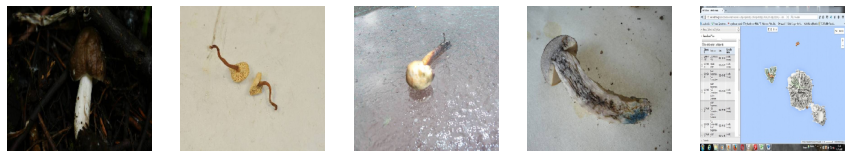

In [ ]:
#optionnal : visualise 5 pictures
mushroom=[next(train_generator) for i in range(0,5)]
fig,ax=plt.subplots(1,5, figsize=(15,6))
print("Genre: ", [item[1][0] for item in mushroom])
for i in range(0,5):
    ax[i].imshow(mushroom[i][0][0].astype("uint8"))
    ax[i].axis("off")


In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
x= inputs
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable=False
x = base_model(x, training=False) # inference mode : batch normalization layers are not trainable if model.trainable=True
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2,activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)



In [ ]:
#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

In [ ]:
#fit

reduceLEarningRate_clbck = tf.keras.callbacks.ReduceLROnPlateau(
     monitor = 'val_loss'
   , factor = tf.math.exp(-0.5)
   , patience = 2   
   , min_lr = 0.00001
   , verbose = 1
)


callback = [reduceLEarningRate_clbck, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)]

history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)
# 97% accuracy

Epoch 1/40
32/32 [==============================] - 13s 282ms/step - loss: 0.2084 - accuracy: 0.9359 - val_loss: 0.1110 - val_accuracy: 0.9615
Epoch 2/40
32/32 [==============================] - 8s 241ms/step - loss: 0.1087 - accuracy: 0.9720 - val_loss: 0.1086 - val_accuracy: 0.9685
Epoch 3/40
32/32 [==============================] - 8s 243ms/step - loss: 0.0650 - accuracy: 0.9780 - val_loss: 0.1173 - val_accuracy: 0.9580
Epoch 4/40
32/32 [==============================] - 8s 242ms/step - loss: 0.0625 - accuracy: 0.9790 - val_loss: 0.1117 - val_accuracy: 0.9615

Epoch 00004: ReduceLROnPlateau reducing learning rate to tf.Tensor(0.0060653067, shape=(), dtype=float32).
Epoch 5/40
32/32 [==============================] - 8s 243ms/step - loss: 0.0516 - accuracy: 0.9810 - val_loss: 0.0978 - val_accuracy: 0.9650
Epoch 6/40
32/32 [==============================] - 8s 242ms/step - loss: 0.0315 - accuracy: 0.9910 - val_loss: 0.0973 - val_accuracy: 0.9685
Epoch 7/40
32/32 [=====================

5/5 [==============================] - 1s 164ms/step - loss: 0.1604 - accuracy: 0.9580


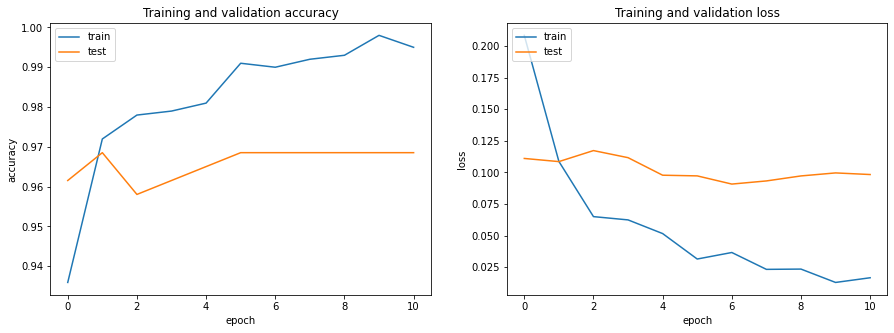

9/9 [==============================] - 3s 182ms/step
              precision    recall  f1-score   support

  champignon       0.97      0.97      0.97       144
       rebus       0.97      0.97      0.97       142

    accuracy                           0.97       286
   macro avg       0.97      0.97      0.97       286
weighted avg       0.97      0.97      0.97       286



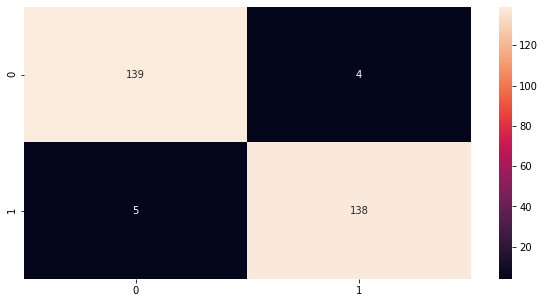

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_8 (Rescaling)         (None, 224, 224, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
normalization_8 (Normalization) (None, 224, 224, 3)  7           rescaling_8[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_8[0][0]            
____________________________________________________________________________________________

In [ ]:
#local configuration

fine_tune_at= 5   # Fine-tune from this layer onwards  THE LAST BLOCK ?!!!
ft_learning_rate= model.optimizer.lr.numpy()
print(ft_learning_rate)
add_epochs= 5

#Fine tuning : unfreeze (all or) part of the model, retrain the model with a very low learning rate

 #model.trainable = True

# Let's take a look to see how many layers are in the base model
#print("Number of layers in the base model: ", len(base_model.layers))
#layers=[(layer,layer.name,layer.trainable) for layer in base_model.layers]
#pd.DataFrame(layers, columns=["layer type", "layer name", "layer trainable"])

# Freeze the last `fine_tune_at` layers
for layer in model.layers[-fine_tune_at:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ft_learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])


history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs+add_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=test_generator)

# => avec last 5, ré entrainer le modèle permet de continuer à gagner un tout petit peu mais NS

0.0036787945
Epoch 6/45
32/32 [==============================] - 13s 285ms/step - loss: 0.0278 - accuracy: 0.9930 - val_loss: 0.2009 - val_accuracy: 0.9615
Epoch 7/45
32/32 [==============================] - 8s 239ms/step - loss: 0.0198 - accuracy: 0.9940 - val_loss: 0.2202 - val_accuracy: 0.9615
Epoch 8/45
32/32 [==============================] - 8s 238ms/step - loss: 0.0215 - accuracy: 0.9930 - val_loss: 0.2075 - val_accuracy: 0.9685

Epoch 00008: ReduceLROnPlateau reducing learning rate to tf.Tensor(0.0022313017, shape=(), dtype=float32).
Epoch 9/45
32/32 [==============================] - 8s 245ms/step - loss: 0.0226 - accuracy: 0.9910 - val_loss: 0.1978 - val_accuracy: 0.9615
Epoch 10/45
32/32 [==============================] - 8s 246ms/step - loss: 0.0173 - accuracy: 0.9950 - val_loss: 0.2077 - val_accuracy: 0.9615
Epoch 11/45
32/32 [==============================] - 8s 240ms/step - loss: 0.0144 - accuracy: 0.9960 - val_loss: 0.2165 - val_accuracy: 0.9615

Epoch 00011: ReduceLROn

Fine tuning the whole model

With data augmentation

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1)
                    ])
x= data_augmentation(inputs)    #preprocessing treatments included in the model 

base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_tensor=x )

base_model.trainable=False 
#build model
x = base_model(x, training=False)  # inference mode
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

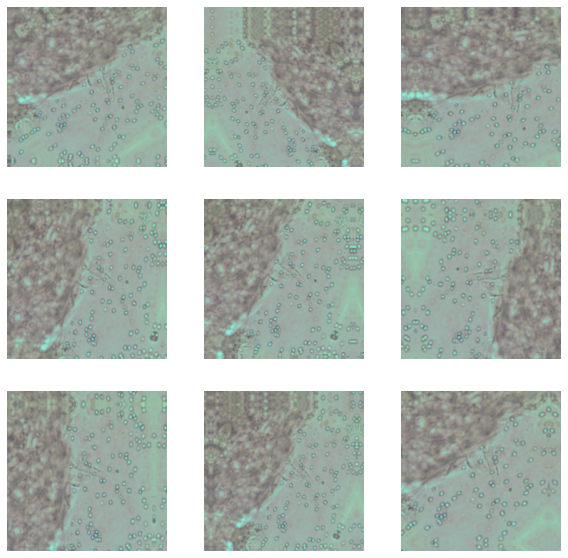

In [ ]:
#optionnal: To visualize the data augmentation 
for images in [next(train_generator) for i in range(0,1)]:
    plt.figure(figsize=(10, 10))
    first_image = images[0][0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        #plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
learning_rate=0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

In [ ]:
#fit

reduceLEarningRate_clbck = tf.keras.callbacks.ReduceLROnPlateau(
     monitor = 'val_loss'
   , factor = tf.math.exp(-0.5)
   , patience = 2   
   , min_lr = 0.00001
   , verbose = 1
)


callback = [reduceLEarningRate_clbck, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)]

history = model.fit(train_generator,
                    callbacks=[callback],
                    epochs=epochs,
                    validation_data=test_generator)



Epoch 1/40
32/32 [==============================] - 14s 285ms/step - loss: 0.2870 - accuracy: 0.9059 - val_loss: 0.1792 - val_accuracy: 0.9615
Epoch 2/40
32/32 [==============================] - 8s 241ms/step - loss: 0.1118 - accuracy: 0.9630 - val_loss: 0.1790 - val_accuracy: 0.9685
Epoch 3/40
32/32 [==============================] - 8s 241ms/step - loss: 0.1084 - accuracy: 0.9670 - val_loss: 0.2055 - val_accuracy: 0.9615
Epoch 4/40
32/32 [==============================] - 8s 241ms/step - loss: 0.0904 - accuracy: 0.9790 - val_loss: 0.1755 - val_accuracy: 0.9720
Epoch 5/40
32/32 [==============================] - 8s 246ms/step - loss: 0.0862 - accuracy: 0.9680 - val_loss: 0.1611 - val_accuracy: 0.9755
Epoch 6/40
32/32 [==============================] - 8s 244ms/step - loss: 0.0754 - accuracy: 0.9780 - val_loss: 0.1730 - val_accuracy: 0.9650
Epoch 7/40
32/32 [==============================] - 8s 243ms/step - loss: 0.0714 - accuracy: 0.9730 - val_loss: 0.1765 - val_accuracy: 0.9615

Epoc

5/5 [==============================] - 1s 167ms/step - loss: 0.1757 - accuracy: 0.9371


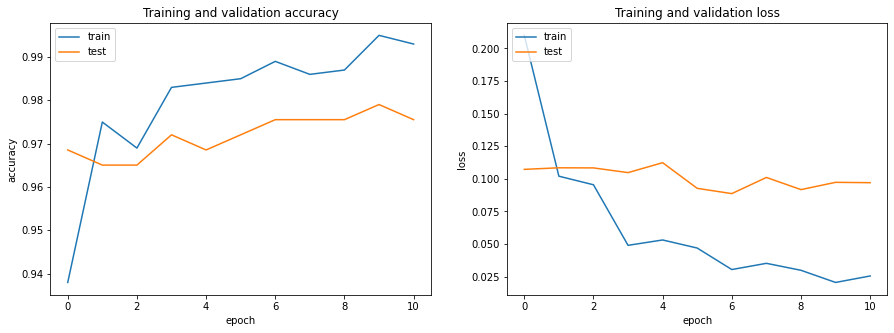

9/9 [==============================] - 3s 181ms/step
              precision    recall  f1-score   support

  champignon       0.98      0.97      0.98       144
       rebus       0.97      0.98      0.98       142

    accuracy                           0.98       286
   macro avg       0.98      0.98      0.98       286
weighted avg       0.98      0.98      0.98       286



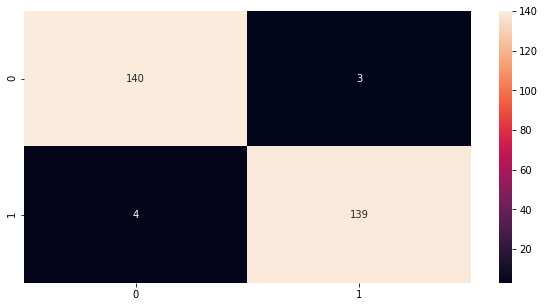

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

5/5 [==============================] - 1s 164ms/step
Path:  /content/drive/MyDrive/work/Oliv/images_rebus_model/rebus/297298.jpg
Path:  /content/drive/MyDrive/work/Oliv/images_rebus_model/rebus/19498.jpg
Path:  /content/drive/MyDrive/work/Oliv/images_rebus_model/rebus/297298.jpg
Path:  /content/drive/MyDrive/work/Oliv/images_rebus_model/rebus/248550.jpg
Path:  /content/drive/MyDrive/work/Oliv/images_rebus_model/rebus/216466.jpg


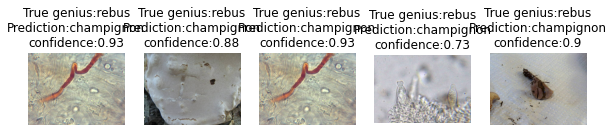

In [ ]:
show_wrong_predictions(model, val_generator)

In [ ]:
model.save(WORK_DIR+ "/saved_model/" + "Is_mushroom_ENetB0.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#Diagnostics functions

In [ ]:
#show model performance
def show_performance(my_model,history):
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  x_epochs=range(len(history.history["accuracy"]))
  plt.plot(x_epochs, history.history["accuracy"])
  plt.plot(x_epochs, history.history["val_accuracy"])
  plt.title("Training and validation accuracy")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  plt.subplot(1,2,2)
  x_epochs=range(len(history.history["loss"]))
  plt.plot(x_epochs, history.history["loss"])
  plt.plot(x_epochs, history.history["val_loss"])
  plt.title("Training and validation loss")
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  test_pred=my_model.predict(x=test_generator, verbose=1)
  test_pred_class=test_pred.argmax(axis=1)
  #y_test_class=pd.get_dummies(X_test.taxon_name).to_numpy().argmax(axis=1)
  y_test_class=test_generator.classes
  print(metrics.classification_report(y_test_class, test_pred_class, target_names=list_genus))
  df_cm=pd.DataFrame(metrics.confusion_matrix(test_pred_class,y_test_class))
  plt.figure(figsize = (10,5))
  sns.heatmap(df_cm, annot=True, fmt="d")


In [ ]:
def show_good_predictions(preprocess_input):
  
  correct_indexes=[]
  for i in range(len(test_generator.filenames)):
    if(test_pred_class[i] == y_test_class[i]):
      correct_indexes.append(i)

  j=1
  plt.figure(figsize=(10, 10))
  for i in np.random.choice(correct_indexes, size=3):
    img=cv2.imread(X_test.img_path.iloc[i])
    plt.subplot(1,3,j)
    j+=1
    plt.axis("off")
    plt.imshow(img )
    plt.title("True genius:" + str(y_test_class[i]) +
              "\n"+ "Prediction:" + str(test_pred_class[i]) + 
              "\n"+ "confidence:" + str(round(test_pred[i][test_pred_class[i]],2)))

In [ ]:
#Show wrong predictions
def show_wrong_predictions(my_model, test_generator):
  test_pred=my_model.predict(x=test_generator, verbose=1)
  test_pred_class=test_pred.argmax(axis=1)
  #y_test_class=pd.get_dummies(X_test.taxon_name).to_numpy().argmax(axis=1)
  y_test_class=test_generator.classes

  error_indexes=[]
  for i in range(len(test_generator.filenames)):
    if(test_pred_class[i] != y_test_class[i]):
      error_indexes.append(i)
  j=1
  plt.figure(figsize=(10, 10))
  for i in np.random.choice(error_indexes, size=5):
    #img=cv2.imread(X_test.img_path.iloc[i])
    img=tf.io.read_file(test_generator.filenames[i])
    img=tf.image.decode_jpeg(img,channels=3)
    plt.subplot(1,5,j)
    j+=1
    plt.axis("off")
    plt.imshow(img )
    plt.title("True genius:" + str(list_genus[y_test_class[i]]) +
              "\n"+ "Prediction:" + str(list_genus[test_pred_class[i]]) + 
              "\n"+ "confidence:" + str(round(test_pred[i][test_pred_class[i]],2)))
    print("Path: ", test_generator.filenames[i])


# Apply CNN and Clean our dataframe

In [ ]:
#Test
folders = [IMG_DIR + "/" + name for name in os.listdir(IMG_DIR)]
files = []
for folder in folders:
    files.append([folder + "/" + name for name in os.listdir(folder)])

for champi in files:
    img_array = get_img_array(champi, size=IMG_SIZE)
    preds = model.predict(img_array)
    if np.argmax(preds)==1:
        print(champi, " =>rebus")

In [8]:
#Load dataframe with 1k images per genus
df_genus = pd.read_csv( \
      filepath_or_buffer = SRC_DIR + '/' + "df_genus.csv"
   ,  sep = ','
   ,  header = 0
)
print("Shape : ",df_genus.shape)
print("Nb of classes : ")
print(df_genus.taxon_name.value_counts())
#specify image link within Google Drive
for i in range(len(df_genus)):
    df_genus.loc[i,"img_path"]= "/content/drive/MyDrive/work/Oliv/images/" + df_genus.loc[i,"taxon_name"] + "/" + str(int(df_genus.loc[i,"image_id"]))+".jpg"


Shape :  (35000, 36)
Nb of classes : 
Cantharellus     1000
Mycena           1000
Stereum          1000
Entoloma         1000
Pluteus          1000
Laccaria         1000
Lactarius        1000
Armillaria       1000
Tylopilus        1000
Crepidotus       1000
Ganoderma        1000
Coprinopsis      1000
Psathyrella      1000
Hygrocybe        1000
Gymnopilus       1000
Suillus          1000
Russula          1000
Tricholoma       1000
Gymnopus         1000
Leucoagaricus    1000
Pholiota         1000
Marasmius        1000
Galerina         1000
Clitocybe        1000
Agaricus         1000
Boletus          1000
Xylaria          1000
Cortinarius      1000
Hebeloma         1000
Amanita          1000
Ramaria          1000
Poria            1000
Agrocybe         1000
Lepiota          1000
Leccinum         1000
Name: taxon_name, dtype: int64


In [9]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size XxX
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (X, X, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, X, X, 3)
    array = np.expand_dims(array, axis=0)
    return array

IMG_SIZE=(224,224)
model= tf.keras.models.load_model(WORK_DIR+ "/saved_model/" + "Is_mushroom_ENetB0.h5")

#Then remove the images from the dataframe : 
for i in range(df_genus.shape[0]):
    print(i)
    try: 
        img_array = get_img_array(df_genus.img_path[i], size=IMG_SIZE)
        preds = model.predict(img_array)
        if np.argmax(preds)==1:
            #copyfile(df_genus.img_path[i], IMG_DIR+ "/rebus_CNN/" + str(int(df_genus.image_id[i])) + ".jpg" )
            print(df_genus.img_path[i], "rebus!")
            df_genus=df_genus.drop([i])
    except:
        df_genus=df_genus.drop([i])
        print("except")
df_genus.reset_index(inplace=True)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
30316
30317
30318
30319
30320
30321
30322
30323
30324
30325
30326
30327
30328
30329
30330
30331
30332
30333
30334
30335
30336
30337
30338
30339
30340
30341
30342
30343
30344
30345
30346
30347
/content/drive/MyDrive/work/Oliv/images/Stereum/570623.jpg rebus!
30348
30349
30350
30351
30352
30353
30354
30355
30356
30357
30358
30359
30360
30361
30362
30363
30364
30365
30366
30367
30368
30369
30370
30371
30372
30373
30374
30375
30376
30377
30378
30379
/content/drive/MyDrive/work/Oliv/images/Stereum/584623.jpg rebus!
30380
30381
30382
30383
30384
30385
30386
30387
30388
30389
30390
30391
30392
30393
30394
30395
30396
30397
30398
30399
30400
30401
30402
30403
30404
30405
30406
30407
30408
30409
30410
30411
30412
30413
30414
/content/drive/MyDrive/work/Oliv/images/Stereum/633924.jpg rebus!
30415
/content/drive/MyDrive/work/Oliv/images/Stereum/640475.jpg rebus!
30416
30417
30418
/content/drive/MyDrive/work/Oliv/images/

In [ ]:
df_genus.to_csv(WORK_DIR + "/" + "df_genus_1k_clean.csv")

In [10]:
df_genus.taxon_name.value_counts()

Leccinum         969
Tricholoma       964
Cantharellus     960
Amanita          958
Lactarius        958
Suillus          948
Armillaria       948
Tylopilus        948
Cortinarius      943
Hygrocybe        942
Lepiota          940
Clitocybe        939
Agaricus         935
Boletus          933
Ramaria          930
Coprinopsis      926
Stereum          925
Russula          924
Laccaria         910
Marasmius        910
Mycena           903
Psathyrella      890
Gymnopus         887
Ganoderma        881
Pholiota         873
Crepidotus       873
Xylaria          854
Entoloma         851
Agrocybe         851
Leucoagaricus    842
Hebeloma         824
Gymnopilus       814
Pluteus          787
Galerina         781
Poria            524
Name: taxon_name, dtype: int64

In [11]:
print("nb d'images filtrées :",  35000 - len(df_genus))
print("soit en % ", (35000 - len(df_genus))/35000)

nb d'images filtrées : 3755
soit en %  0.10728571428571429


In [60]:
#Now load dataframe with 2k images per genus
df_genus = pd.read_csv( \
      filepath_or_buffer = SRC_DIR + '/' + "df_genus_2k.csv"
   ,  sep = ','
   ,  header = 0
)
print("Shape : ",df_genus.shape)
print("Nb of classes : ")
print(df_genus.taxon_name.value_counts())

#specify image link within Google Drive
for i in range(len(df_genus)):
    df_genus.loc[i,"img_path"]= "/content/drive/MyDrive/work/Oliv/images_clean/" + df_genus.loc[i,"taxon_name"] + "/" + str(int(df_genus.loc[i,"image_id"]))+".jpg"


Shape :  (30000, 36)
Nb of classes : 
Marasmius      2000
Lactarius      2000
Gymnopilus     2000
Psathyrella    2000
Entoloma       2000
Armillaria     2000
Cortinarius    2000
Amanita        2000
Agaricus       2000
Mycena         2000
Hygrocybe      2000
Xylaria        2000
Russula        2000
Pluteus        2000
Gymnopus       2000
Name: taxon_name, dtype: int64


In [61]:
#Then remove the images from the dataframe : 
for i in range(df_genus.shape[0]):
    print(i)
    try: 
        img_array = get_img_array(df_genus.img_path[i], size=IMG_SIZE)
        preds = model.predict(img_array)
        if np.argmax(preds)==1:
            #copyfile(df_genus.img_path[i], IMG_DIR+ "/rebus_CNN/" + str(int(df_genus.image_id[i])) + ".jpg" )
            print(df_genus.img_path[i], "rebus!")
            df_genus=df_genus.drop([i])
    except:
        df_genus=df_genus.drop([i])
        print("except")
df_genus.reset_index(inplace=True)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
25531
/content/drive/MyDrive/work/Oliv/images_clean/Psathyrella/249836.jpg rebus!
25532
25533
25534
25535
25536
25537
25538
25539
25540
25541
25542
25543
25544
25545
25546
25547
25548
25549
25550
25551
25552
25553
25554
25555
25556
25557
25558
25559
25560
/content/drive/MyDrive/work/Oliv/images_clean/Psathyrella/253457.jpg rebus!
25561
25562
25563
25564
25565
25566
25567
25568
25569
25570
25571
25572
25573
25574
25575
25576
25577
25578
25579
25580
25581
25582
25583
25584
25585
25586
25587
25588
25589
/content/drive/MyDrive/work/Oliv/images_clean/Psathyrella/258710.jpg rebus!
25590
/content/drive/MyDrive/work/Oliv/images_clean/Psathyrella/258711.jpg rebus!
25591
/content/drive/MyDrive/work/Oliv/images_clean/Psathyrella/258712.jpg rebus!
25592
25593
25594
25595
25596
25597
25598
25599
25600
25601
25602
25603
25604
/content/drive/MyDrive/work/Oliv/images_clean/Psathyrella/261498.jpg rebus!
25605
25606
25607
2560

In [62]:
df_genus.taxon_name.value_counts()

Amanita        1927
Armillaria     1899
Hygrocybe      1899
Lactarius      1887
Agaricus       1884
Gymnopus       1852
Cortinarius    1837
Russula        1816
Marasmius      1800
Entoloma       1759
Mycena         1753
Psathyrella    1738
Xylaria        1685
Pluteus        1673
Gymnopilus     1671
Name: taxon_name, dtype: int64

In [63]:
print("nb d'images filtrées :",  30000 - len(df_genus))
print("soit en % ", (30000 - len(df_genus))/30000)

nb d'images filtrées : 2920
soit en %  0.09733333333333333


In [ ]:
df_genus.to_csv(WORK_DIR + "/" + "df_genus_2k_clean.csv")